In [1]:
import os
import time
import glob
import pandas as pd
import numpy  as np
import tables as tb

import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm     as cm

from mpl_toolkits               import mplot3d
from mpl_toolkits.mplot3d       import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from invisible_cities.cities.esmeralda import esmeralda
from invisible_cities.core             import system_of_units as units
from invisible_cities.core.configure   import configure
from invisible_cities.core.configure   import all             as all_events

from invisible_cities.database import load_db

In [2]:
plt.rcParams["font.size"]      = 15
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"

In [3]:
inputfilename = os.path.expandvars("$LUSTRE/NEXT100/0nubb/detsim/prod/penthesilea/penthesilea_0_0nubb.h5")

In [147]:
pes = units.pes
mus = units.mus
keV = units.keV
mm  = units.mm

conf = configure('esmeralda $ICTDIR/invisible_cities/config/esmeralda.conf'.split())

conf["files_in"]    = inputfilename
conf["file_out"]    = "test.h5"
conf["compression"] = "ZLIB4"
conf["run_number"]  = 0
conf["detector_db"] = "next100"
conf["event_range"] = (0, 10)
conf["print_mod"]   = 1

conf["cor_hits_params"] = dict(map_fname = "$LUSTRE/NEXT100/kr83m/detsim/map_NEXT100_detsim.h5",
                               threshold_charge_low  =  1 * pes,
                               threshold_charge_high = 30 * pes, #nominal 30 pes
                               same_peak             = True,
                               norm_strat            = 'kr',
                               apply_temp            = False)

conf["paolina_params"] = dict(vox_size         = [15 * mm, 15 * mm, 15 * mm],
                              strict_vox_size  = False,
                              energy_threshold = 0 * keV, #nominal 20keV
                              min_voxels       = 3,
                              blob_radius      = 21 * mm,
                              max_num_hits     = 30000)

In [148]:
t0 = time.time()

result = esmeralda(**conf)

print("Exec (s)", time.time()-t0)

events processed: 0, event number: 0
events processed: 1, event number: 8
events processed: 2, event number: 16
events processed: 3, event number: 24
events processed: 4, event number: 32
events processed: 5, event number: 40
events processed: 6, event number: 48
events processed: 7, event number: 56
events processed: 8, event number: 64
events processed: 9, event number: 72
Exec (s) 12.391907930374146


In [149]:
CHITS   = pd.read_hdf(conf["file_out"], "CHITS/highTh")   .set_index("event")
Tracks  = pd.read_hdf(conf["file_out"], "Tracking/Tracks").set_index("event")
Summary = pd.read_hdf(conf["file_out"], "Summary/Events") .set_index("event")
DST     = pd.read_hdf(conf["file_out"], "DST/Events")     .set_index("event")

MCHITS  = pd.read_hdf(conf["file_out"], "MC/hits").set_index("event_id")

eventMap = pd.read_hdf(conf["file_out"], "Run/eventMap").set_index("evt_number")

In [150]:
event = 8

chits   = CHITS  .loc[[event]]
tracks  = Tracks .loc[[event]]
summary = Summary.loc[[event]]
dst     = DST    .loc[[event]]

mchits  = MCHITS .loc[eventMap.loc[event].values[0]]

In [151]:
fig = plt.figure()
ax = fig.gca(projection='3d')

for track_id, track in tracks.groupby("trackID"):
    hits = chits[chits["track_id"]==track_id]
    
    # plot
    norm   = colors.Normalize(vmin=0, vmax=hits["E"].max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

    # chits
    ax.scatter(hits["X"], hits["Y"], hits["Z"], color=mapper.to_rgba(hits["E"]), alpha=0.2)

    # mchits
    ax.scatter(mchits["x"], mchits["y"], mchits["z"], c="r", s=1)

    # blobs
    ax.scatter(track["blob1_x"], track["blob1_y"], track["blob1_z"], marker="*", s=200, c="k")
    ax.scatter(track["blob2_x"], track["blob2_y"], track["blob2_z"], marker="*", s=200, c="k")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
voxels = []
for x, y, z in zip(xs, ys, zs):
    
    x1, x2 = x-vox_x/2., x+vox_x/2.
    y1, y2 = y-vox_y/2., y+vox_y/2.
    z1, z2 = z-vox_z/2., z+vox_z/2.
    
    verts = np.array([(x1, y1, z1), (x1, y1, z2), (x1, y2, z1), (x1, y2, z2),
                      (x2, y1, z1), (x2, y1, z2), (x2, y2, z1), (x2, y2, z2)])
    voxels.append(verts)
    break

In [13]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # ax = fig.gca(projection='3d')

# ax.add_collection3d(p)

In [11]:
def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt(positions, sizes=None, colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]     *len(positions)
    if not isinstance(sizes ,(list,np.ndarray)): sizes =[(1 , 1 ,1)]*len(positions)
    g = []
    for p,s,c in zip(positions, sizes, colors):
        g.append( cuboid_data(p, size=s) )
    return Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6, axis=0), **kwargs)

In [24]:
positions = np.concatenate([xs[:, np.newaxis], ys[:, np.newaxis], zs[:, np.newaxis]], axis=1)[:2]
colors= np.random.rand(len(positions), 3)
sizes = [(vox_x, vox_y, vox_z)] *len(positions)

In [26]:
positions

array([[365.425     , -69.975     , 300.506625  ],
       [365.425     , -69.975     , 301.50459375]])

In [25]:
fig = plt.figure()
ax = fig.gca(projection='3d')

pc = plotCubeAt(positions, colors=colors, sizes=sizes, edgecolor="k")
ax.add_collection3d(pc)

ax.set_xlim([min(xs)-10, max(xs)+10])
ax.set_ylim([min(ys)-10, max(ys)+10])
ax.set_zlim([min(zs)-10, max(zs)+10])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(255.51768750000002, 316.42878125)

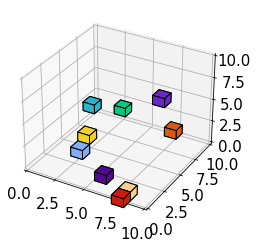

In [26]:
def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt(positions, sizes=None, colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]   *len(positions)
    if not isinstance(sizes ,(list,np.ndarray)): sizes =[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data(p, size=s) )
    return Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6, axis=0), **kwargs)

N1 = 10
N2 = 10
N3 = 10

ma = np.random.choice([0,1], size=(N1,N2,N3), p=[0.99, 0.01])
x,y,z = np.indices((N1,N2,N3))-.5

positions = np.c_[x[ma==1],y[ma==1],z[ma==1]]
colors= np.random.rand(len(positions),3)

fig = plt.figure()
ax = fig.gca(projection='3d')

pc = plotCubeAt(positions, colors=colors, edgecolor="k")
ax.add_collection3d(pc)

ax.set_xlim([0,10])
ax.set_ylim([0,10])
ax.set_zlim([0,10])

plt.show()